![Logo](assets/logo.png)

Made by **Domonkos Nagy**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/7.%20Planning%20and%20Learning/maze.ipynb)

# Maze

In this notebook we consider the problem of solving a maze in only a few episodes.

![Example](assets/maze.gif)

This maze environment was originally made with the `gym` library, but we apply an API compatibility layer, so it behaves exactly like
a `gymnasium` environment. The states are the x, y coordinates of the agent (which we transform to be respresented by a single integer), and the actions are the 4 directions: 'N', 'S', 'E' and 'W'. The reward
is -0.1/(number of cells) for each step, and for reaching the goal, a reward of +1 is received.

The maze is randomly generated every time the environment is created. To find the optimal path in only a small number of episodes, we are going to use
*Prioritized Sweeping*.

- Documentation for the Maze environment: https://github.com/MattChanTK/gym-maze

In [22]:
import gym
import gym_maze
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from gymnasium.wrappers import TransformObservation
import warnings
warnings.filterwarnings('ignore')

In [23]:
# initializing gym environment with gymnasium compatibility
env = gym.make("maze-random-10x10-v0", apply_api_compatibility=True)
# transforming observation representation from array to int: e.g. [3, 4] -> 43
env = TransformObservation(env, lambda obs: int(obs[1] * (env.observation_space.high + 1)[0] + obs[0]))

In [24]:
# initializing q-table
action_space_size = env.action_space.n
observation_space_size = (env.observation_space.high + 1)[0] * \
    (env.observation_space.high + 1)[1]
shape = observation_space_size, action_space_size

q_table = np.zeros(shape)

# initializing model
model_state = np.zeros(shape)
model_reward = np.zeros(shape)

# initializing priority queue
priorities = np.zeros(shape)

In [25]:
# argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

In [26]:
# class representing our model of the environment
class Model:
    def __init__(self, shape):
        self.states = np.zeros(shape, dtype=int) - 1
        self.rewards = np.zeros(shape)
        self.states_reverse = {}

    # add new information to the model:
    # taking 'action' in 'state' produces 'reward'
    # and transfers the agent to 'new_state'
    def add(self, state, action, reward, new_state):
        self.states[state, action] = new_state
        self.rewards[state, action] = reward

        if new_state in self.states_reverse:
            if not (state, action) in self.states_reverse[new_state]:
                self.states_reverse[new_state].append((state, action))
        else:
            self.states_reverse[new_state] = [(state, action)]

    # get information from the model:
    def get(self, state, action):
        new_state = self.states[state, action]
        reward = self.rewards[state, action]
        return new_state, reward

    # get all state-action pairs that lead the agent to 'state'
    def get_leading(self, state):
        return self.states_reverse[state]

In [27]:
# initializing model
model = Model(shape)

In [28]:
# hyperparameters
N_EPISODES = 3
N_UPDATES_PER_STEP = 200  # planning updates per interaction with the environment

ALPHA = 0.7  # learning rate
GAMMA = 1  # discount rate
THETA = 0.01  # priority treshold
C = 5  # exploration rate (UCB)

In [29]:
def plan():
    for _ in range(N_UPDATES_PER_STEP):
        # get state-action pair with highest priority
        state, action = np.unravel_index(priorities.argmax(), priorities.shape)
        if priorities[state, action] == 0:
            break
            
        # reset priority
        priorities[state, action] = 0

        # get new state and reward from model
        new_state, reward = model.get(state, action)

        # update q-table
        q_table[state, action] = q_table[state, action] * (1 - ALPHA) + \
            ALPHA * (reward + GAMMA * np.max(q_table[new_state, :]))

        # add leading states to queue
        for prev_state, prev_action in model.get_leading(state):
            _, prev_reward = model.get(prev_state, prev_action)
            priority = abs(prev_reward + GAMMA *
                           np.max(q_table[state, :] - q_table[prev_state, prev_action]))

            if priorities[prev_state, prev_action] < priority and priority > THETA:
                priorities[prev_state, prev_action] = priority

In [30]:
for episode in range(N_EPISODES):
    state, _ = env.reset()
    done = False
    n = 0
    selections = np.zeros(shape)

    while not done:
        n += 1
    
        # UCB action selection
        UCB_estimations = q_table[state, :] + C * np.sqrt(np.log(n) / (selections[state, :] + 1e-5))
        action = argmax(UCB_estimations)
    
        selections[state, action] += 1
    
        # take the selected action
        new_state, reward, done, truncated, info = env.step(['N', 'S', 'E', 'W'][action])
        # add information to the model
        model.add(state, action, reward, new_state)
    
        # add state-action pair to queue
        priority = abs(reward + GAMMA *
                       np.max(q_table[new_state, :] - q_table[state, action]))
            
        if priorities[state, action] < priority and priority > THETA:
            priorities[state, action] = priority
    
        state = new_state
        plan()

    print(f'Episode {episode}:\n\tSteps: {n}\n\tQueue size: {np.count_nonzero(priorities)}')

Episode 0:
	Steps: 2949
	Queue size: 66
Episode 1:
	Steps: 38
	Queue size: 91
Episode 2:
	Steps: 32
	Queue size: 48


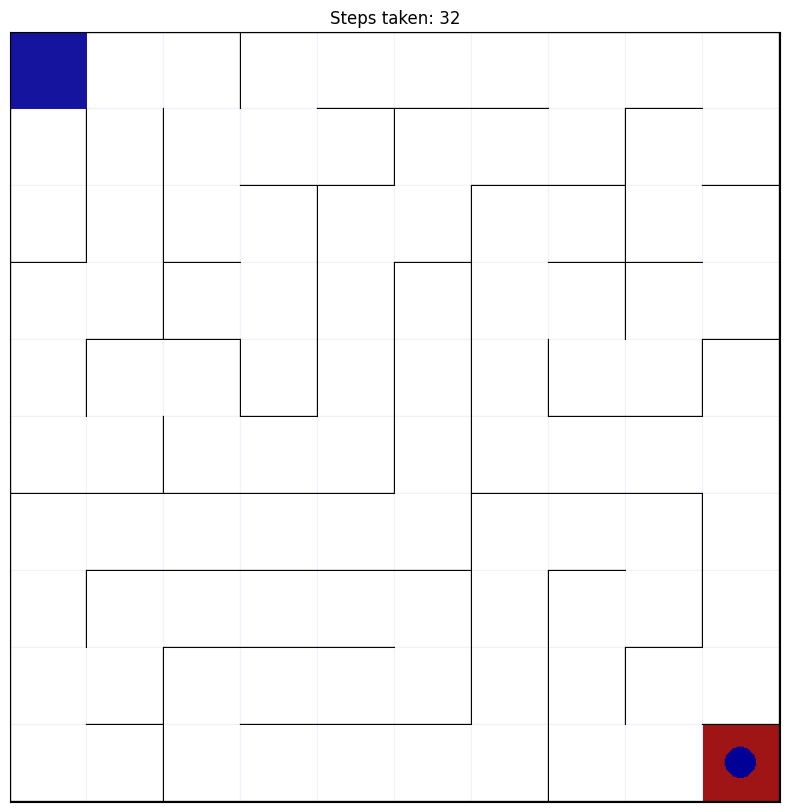

In [31]:
# create figure
plt.figure(figsize=(10, 10))
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

# render starting state
state, _ = env.reset()
img = plt.imshow(env.render())

done = False
sum_reward = 0
n_steps = 0

# play episode
while not done:
    # greedy action selection
    action = argmax(q_table[state, :])

    # take the selected action
    new_state, reward, done, truncated, info = env.step(['N', 'S', 'E', 'W'][action])
    sum_reward += reward
    n_steps += 1

    # render state
    img.set_data(env.render())
    plt.title(f'Steps taken: {n_steps}')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = new_state